<a href="https://colab.research.google.com/github/natsakh/IAD/blob/main/Pr_6/6_4_Timeseries_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

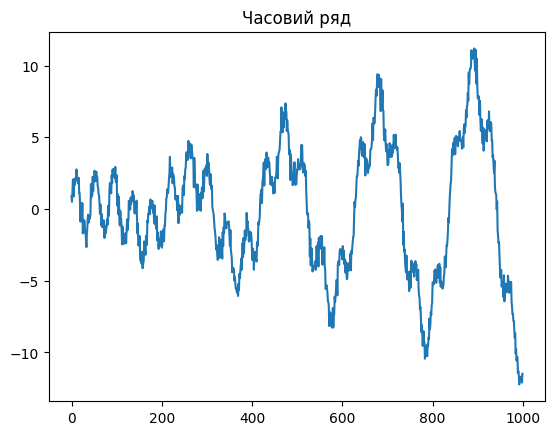

In [2]:
#Згенеруємо часовий ряд
time_series_length = 1000
t = np.linspace(0, 30, time_series_length)
ts = t * np.sin(t) / 3 + 2 * np.sin(t*5) + 0.5 * np.random.standard_normal(size=time_series_length)

plt.plot(ts); plt.title("Часовий ряд"); plt.show()

In [3]:
#Split
train_size = int(len(ts) * 0.9)
train_raw = ts[:train_size]
test_raw  = ts[train_size:]

# Обчислюємо статистики на train
mu  = train_raw.mean()
std = train_raw.std() + 1e-8  # на випадок дуже малого std

# Нормалізуємо train і test одним і тим самим (mu, std)
train = (train_raw - mu) / std
test  = (test_raw  - mu) / std

# для візуалізації:
ts_norm = np.concatenate([train, test])

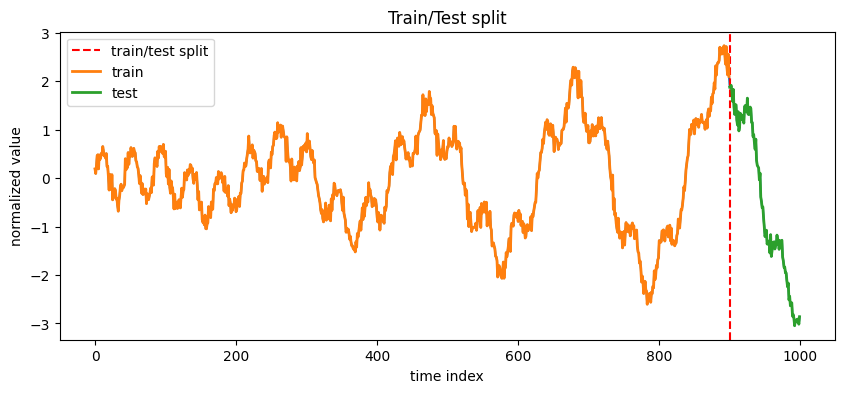

In [4]:
plt.figure(figsize=(10,4))
plt.plot(ts_norm)
plt.axvline(x=train_size, color='red', linestyle='--', label='train/test split')

plt.plot(range(train_size), train, label='train', linewidth=2)
plt.plot(range(train_size, len(ts_norm)), test, label='test', linewidth=2)

plt.title("Train/Test split")
plt.xlabel("time index")
plt.ylabel("normalized value")
plt.legend()
plt.show()


In [5]:
#   Функція створення вибірок-вікон
#    X: послідовності довжини time_steps
#    y: наступне за вікном значення

def create_dataset(series, time_steps=10):
    X, y = [], []
    for i in range(len(series) - time_steps):
        X.append(series[i:i+time_steps])
        y.append(series[i+time_steps])
    return np.array(X), np.array(y)

In [6]:
n_time_steps = 10
x_train, y_train = create_dataset(train, n_time_steps)
x_test,  y_test  = create_dataset(test,  n_time_steps)

# Додаємо вимір "кількість ознак" = 1: [batch, seq_len, n_features]
x_train = x_train.reshape(x_train.shape[0], n_time_steps, 1)
x_test  = x_test.reshape(x_test.shape[0],  n_time_steps, 1)

x_train.shape, y_train.shape

((890, 10, 1), (890,))

In [7]:
#Тензори та DataLoader

Xtr = torch.from_numpy(x_train).float().to(device)
Ytr = torch.from_numpy(y_train).float().to(device).unsqueeze(1)  # [B, 1]
Xte = torch.from_numpy(x_test ).float().to(device)
Yte = torch.from_numpy(y_test ).float().to(device).unsqueeze(1)

train_loader = DataLoader(TensorDataset(Xtr, Ytr), batch_size=32, shuffle=True)


In [8]:
# Модель LSTM + Linear
class LSTMRegressor(nn.Module):
    def __init__(self, input_size=1, hidden_size=100):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            batch_first=True)   # [B, T, C]
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # out: [B, T, H]; беремо останній крок часу
        out, _ = self.lstm(x)
        last = out[:, -1, :]           # [B, H]
        return self.fc(last)           # [B, 1]

model = LSTMRegressor(input_size=1, hidden_size=100).to(device)
sum(p.numel() for p in model.parameters()), model
# LSTM має 4 FC шари
#W_ih (вхідні ваги) → розмір [hidden_size, input_size]
#W_hh (рекурентні ваги) → розмір [hidden_size, hidden_size]
#b_ih і b_hh (bias) → кожен розмір [hidden_size]
#тому формула кількості параметрів:
#ParamsLSTM​=4×(hidden_size×(input_size+hidden_size+2))
#ParamsLSTM​=4×(100×(1+100+2))=4×(100×103)=4×10300=41200
#Лінійний шар: ваги: 100 × 1 = 100 + bias: 1 -> 101

(41301,
 LSTMRegressor(
   (lstm): LSTM(1, 100, batch_first=True)
   (fc): Linear(in_features=100, out_features=1, bias=True)
 ))

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [10]:
epochs = 10
for ep in range(1, epochs+1):
    # ===== TRAIN =====
    model.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)

    train_loss /= len(train_loader.dataset)

    # ===== EVAL =====
    model.eval()
    with torch.no_grad():
        y_pred_test = model(Xte)
        test_loss = criterion(y_pred_test, Yte).item()

    print(f"Epoch {ep:2d}/{epochs} | train_loss: {train_loss:.4f} | test_loss: {test_loss:.4f}")


Epoch  1/10 | train_loss: 0.5850 | test_loss: 0.3024
Epoch  2/10 | train_loss: 0.1309 | test_loss: 0.2006
Epoch  3/10 | train_loss: 0.0778 | test_loss: 0.1286
Epoch  4/10 | train_loss: 0.0536 | test_loss: 0.0755
Epoch  5/10 | train_loss: 0.0409 | test_loss: 0.0676
Epoch  6/10 | train_loss: 0.0355 | test_loss: 0.0748
Epoch  7/10 | train_loss: 0.0367 | test_loss: 0.0355
Epoch  8/10 | train_loss: 0.0360 | test_loss: 0.0382
Epoch  9/10 | train_loss: 0.0327 | test_loss: 0.0458
Epoch 10/10 | train_loss: 0.0313 | test_loss: 0.0328


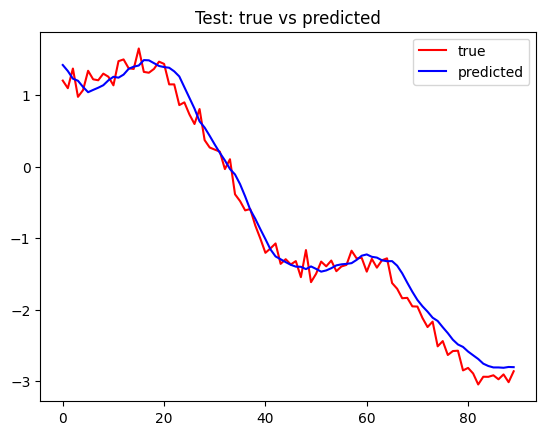

In [11]:
model.eval()
with torch.no_grad():
    y_pred = model(Xte).squeeze(1).cpu().numpy()

plt.plot(y_test, 'r', label='true')
plt.plot(y_pred, 'b', label='predicted')
plt.legend(); plt.title("Test: true vs predicted"); plt.show()